✅ Dataset finale pronto
  Company  Year Category   Revenue    EBITDA  Net_Income  Revenue_lag1  \
5    AAPL  2017       IT  229234.0   71501.0     48351.0      215639.0   
4    AAPL  2018       IT  265595.0   81801.0     59531.0      229234.0   
3    AAPL  2019       IT  260174.0   76477.0     55256.0      265595.0   
2    AAPL  2020       IT  274515.0   77344.0     57411.0      260174.0   
1    AAPL  2021       IT  365817.0  120233.0     94680.0      274515.0   

   Revenue_lag2  EBITDA_lag1  EBITDA_lag2  ...  logRev_lag2  logEBITDA_lag1  \
5      233715.0      70529.0      82487.0  ...    12.361862       11.163793   
4      215639.0      71501.0      70529.0  ...    12.281366       11.177481   
3      229234.0      81801.0      71501.0  ...    12.342503       11.312057   
2      265595.0      76477.0      81801.0  ...    12.489732       11.244758   
1      260174.0      77344.0      76477.0  ...    12.469110       11.256031   

   logNI_lag1  SP500_growth  Nasdaq_growth  Inflation  S

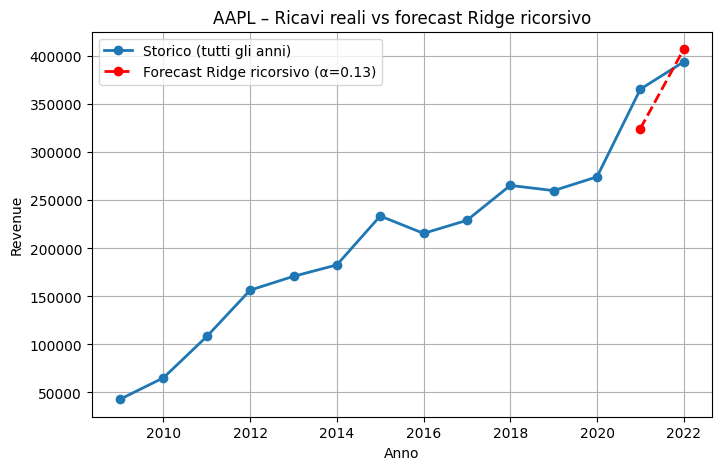

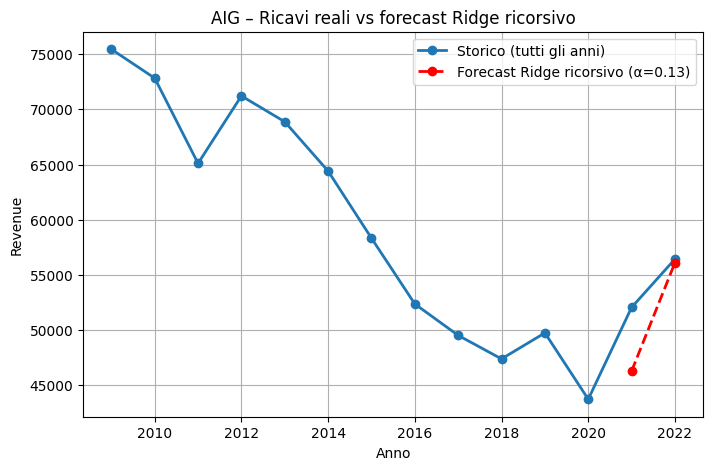

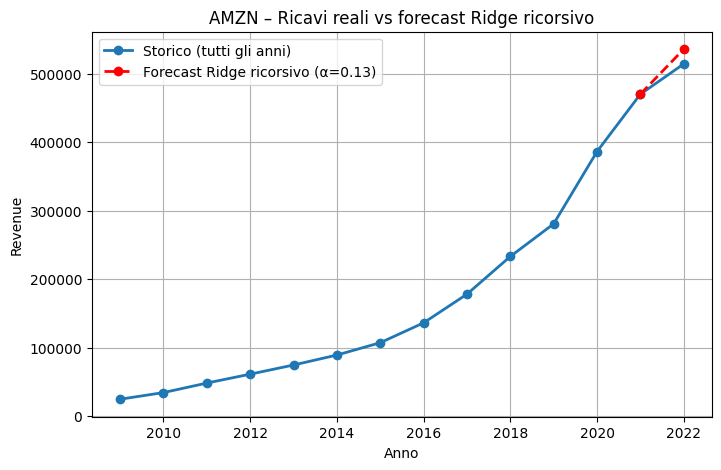

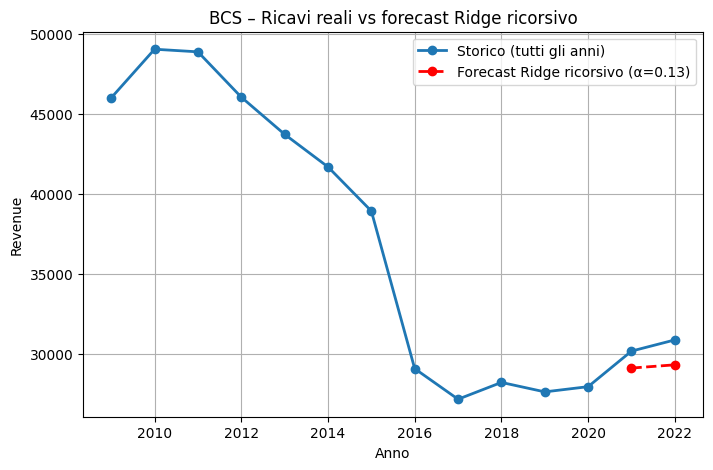

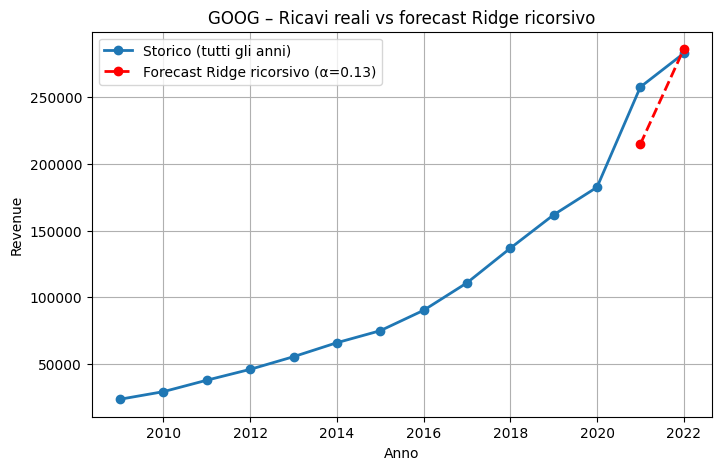

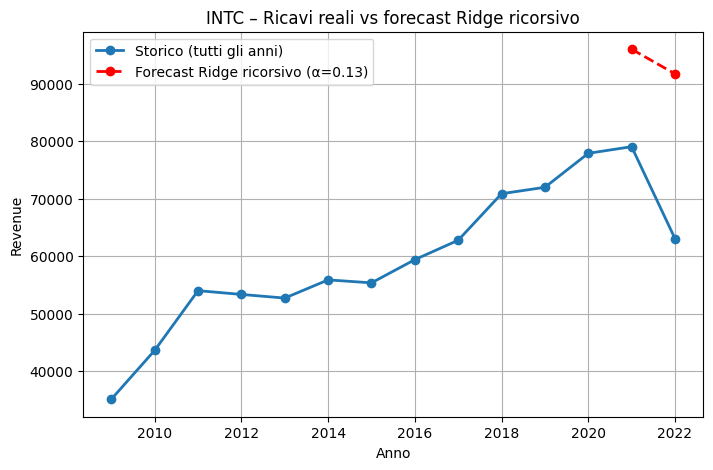

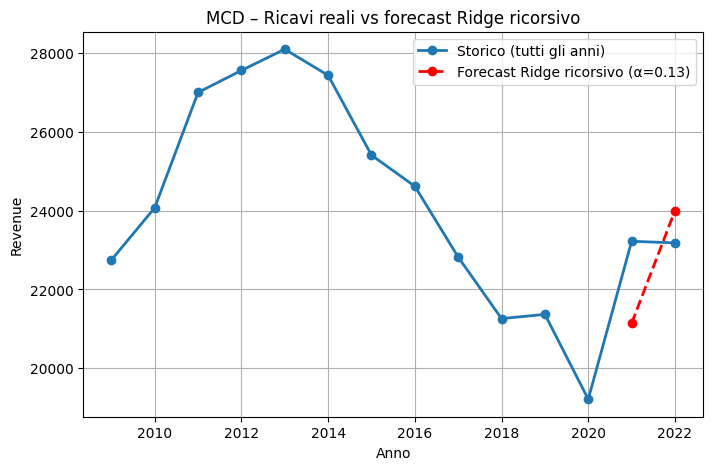

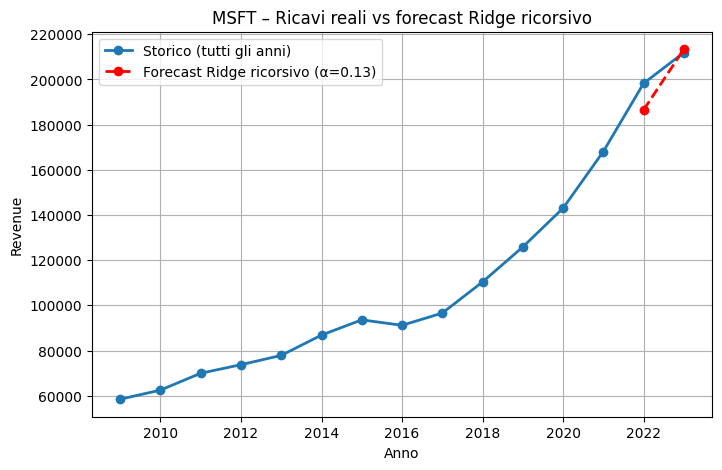

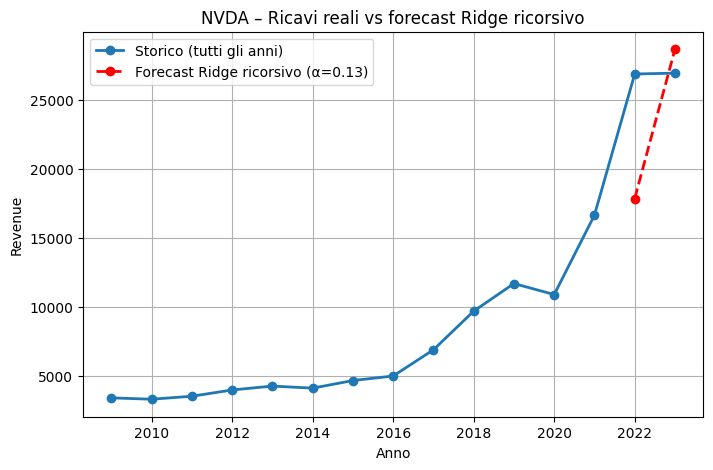

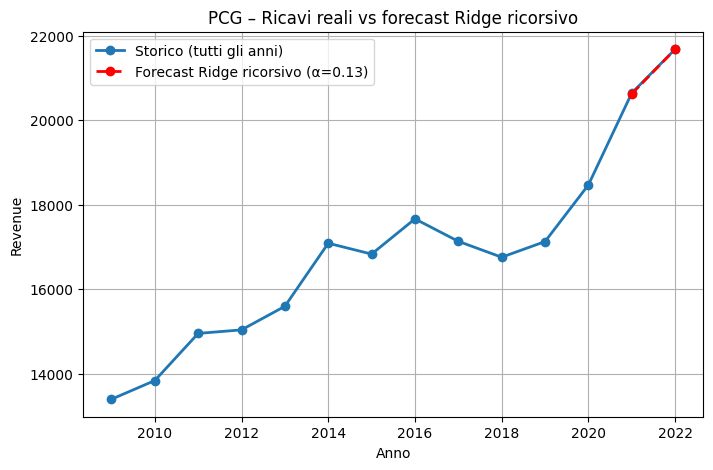

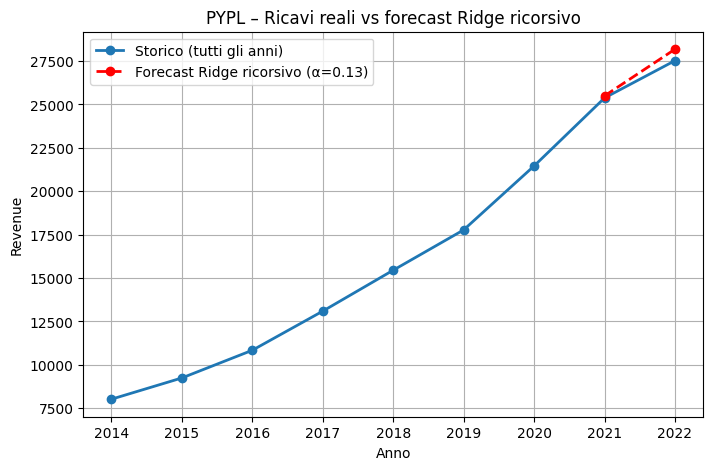


📊 Metriche Ridge (alpha = 0.13) ricorsivo per azienda:
   Company     MAE_model  MAPE_model
0     AAPL  27061.327295    7.267924
1      AIG   3049.576279    5.833897
2     AMZN  10831.818614    2.108922
3      BCS   1307.966836    4.277027
4     GOOG  22974.957270    8.863518
5     INTC  22789.195863   33.427767
6      MCD   1452.555913    6.257908
7     MSFT   6621.310774    3.315666
8     NVDA   5383.477627   19.995343
9      PCG     11.040621    0.053093
10    PYPL    388.967057    1.431900

📊 Medie complessive Ridge ricorsivo (alpha = 0.13):
MAE modello   = 9261.10855889581
MAPE modello  = 8.439360383177053 %


In [40]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import pandas_datareader.data as web

# --- CARICAMENTO ---
df = pd.read_csv("/Users/GeorgKhella/Desktop/Financial Statements.csv")

# --- PULIZIA NOMI COLONNE ---
df.columns = df.columns.str.strip().str.replace(" ", "_")

# --- NORMALIZZA SETTORE ---
df["Category"] = df["Category"].str.strip().str.upper()

# --- SELEZIONE VARIABILI CHIAVE ---
df_extra = df[['Company','Year','Category','Revenue','EBITDA','Net_Income']].copy()
df_extra = df_extra.sort_values(['Company','Year'])

# --- LAG BASE ---
for col in ['Revenue','EBITDA','Net_Income']:
    df_extra[f'{col}_lag1'] = df_extra.groupby('Company')[col].shift(1)
    df_extra[f'{col}_lag2'] = df_extra.groupby('Company')[col].shift(2)

# --- FEATURE ENGINEERING SOLO CON INFO FINO A t-1 ---
df_extra['Rev_growth_lag1'] = (df_extra['Revenue_lag1'] / df_extra['Revenue_lag2']) - 1
df_extra['EBITDA_margin_lag1'] = df_extra['EBITDA_lag1'] / df_extra['Revenue_lag1'].replace(0, np.nan)
df_extra['NI_margin_lag1']     = df_extra['Net_Income_lag1'] / df_extra['Revenue_lag1'].replace(0, np.nan)

# --- LOG TRASFORMAZIONI ---
df_extra['logRev']      = np.log1p(df_extra['Revenue'])
df_extra['logRev_lag1'] = np.log1p(df_extra['Revenue_lag1'])
df_extra['logRev_lag2'] = np.log1p(df_extra['Revenue_lag2'])
df_extra['logEBITDA_lag1'] = np.sign(df_extra['EBITDA_lag1']) * np.log1p(np.abs(df_extra['EBITDA_lag1']))
df_extra['logNI_lag1']     = np.sign(df_extra['Net_Income_lag1']) * np.log1p(np.abs(df_extra['Net_Income_lag1']))

# --- DATI MACRO DA FRED ---
start = "2000-01-01"
end   = "2024-12-31"

sp500 = web.DataReader("SP500", "fred", start, end)          # S&P500 index
nasdaq = web.DataReader("NASDAQCOM", "fred", start, end)     # Nasdaq Composite
cpi = web.DataReader("CPIAUCSL", "fred", start, end)         # CPI USA

# Calcola variazioni annuali
sp500_growth = sp500.resample("YE").last().pct_change().rename(columns={"SP500":"SP500_growth"})
nasdaq_growth = nasdaq.resample("YE").last().pct_change().rename(columns={"NASDAQCOM":"Nasdaq_growth"})
cpi_growth = cpi.resample("YE").mean().pct_change().rename(columns={"CPIAUCSL":"Inflation"})

# Merge macro
macro = pd.concat([sp500_growth, nasdaq_growth, cpi_growth], axis=1).dropna()
macro.index = macro.index.year
df_extra = df_extra.merge(macro, left_on="Year", right_index=True, how="left")

# Lag per variabili macro
for col in ["SP500_growth","Nasdaq_growth","Inflation"]:
    df_extra[f"{col}_lag1"] = df_extra.groupby("Company")[col].shift(1)
df_extra["Year_lag1"] = df_extra.groupby("Company")["Year"].shift(1)

# --- PULIZIA RIGHE INUTILIZZABILI ---
df_extra.replace([np.inf, -np.inf], np.nan, inplace=True)
df_extra = df_extra.dropna(subset=[
    'logRev','logRev_lag1','logRev_lag2',
    'Rev_growth_lag1','EBITDA_margin_lag1','NI_margin_lag1',
    'logEBITDA_lag1','logNI_lag1',
    "SP500_growth_lag1","Nasdaq_growth_lag1","Inflation_lag1"
])

print("✅ Dataset finale pronto")
print(df_extra.head())

# --- DATASET GREZZO SOLO PER I PLOT ---
df_raw = df[['Company','Year','Revenue']].copy()

# --- FORMULA FORECAST ---
formula_forecast = (
    "logRev ~ logRev_lag1 "
    "+ EBITDA_margin_lag1 + NI_margin_lag1 "
    "+ logEBITDA_lag1 + logNI_lag1 "
    "+ SP500_growth_lag1 + Nasdaq_growth_lag1 + Inflation_lag1 "
    "+ C(Category) + C(Year_lag1)"
)

# --- METRICHE ---
def mae(y_true, y_pred):  
    return np.mean(np.abs(y_true - y_pred))

def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# --- VALIDAZIONE RIDGE RICORSIVO ---
def validate_models_ridge_recursive(df_extra, df_raw, alpha=0.13, exclude=[]):
    rows = []
    for comp in df_extra["Company"].unique():
        if comp in exclude:
            continue
        g = df_extra[df_extra["Company"] == comp]
        if g["Year"].nunique() < 4:  # serve almeno spazio per lag + test
            continue

        try:
            # cutoff = ultimo anno disponibile - 2
            cutoff = g["Year"].max() - 2
            df_train = df_extra[~((df_extra["Company"] == comp) & (df_extra["Year"] > cutoff))].copy()
            df_test  = df_extra[(df_extra["Company"] == comp) & (df_extra["Year"] > cutoff)].copy()
            group_raw = df_raw[df_raw["Company"] == comp]

            # modello Ridge stimato su train
            model_ridge = smf.ols(formula=formula_forecast, data=df_train)
            res_ridge = model_ridge.fit_regularized(method='elastic_net', alpha=alpha, L1_wt=0)

            preds_rev = []
            preds_years = []

            # df_temp = copia del train, serve come "storia aggiornata"
            df_temp = df_train.copy()

            # Forecast ricorsivo: anno per anno
            for y in sorted(df_test["Year"].unique()):
                df_y = df_test[df_test["Year"] == y].copy()

                # usa il modello stimato su df_train (non si riadatta ogni anno)
                pred_log = res_ridge.predict(df_y).iloc[0]
                pred_rev = np.expm1(pred_log)

                preds_rev.append(pred_rev)
                preds_years.append(y)

                # aggiorna df_y con valore PREDETTO (serve come lag per anno successivo)
                df_y.loc[:, "Revenue"] = pred_rev
                df_y.loc[:, "logRev"] = np.log1p(pred_rev)
                df_y.loc[:, "Revenue_lag1"] = pred_rev
                df_temp = pd.concat([df_temp, df_y], ignore_index=True)

            # --- plot ---
            plt.figure(figsize=(8,5))
            plt.plot(group_raw["Year"], group_raw["Revenue"], marker="o", linewidth=2, label="Storico (tutti gli anni)")
            plt.plot(preds_years, preds_rev, marker="o", linestyle="--", linewidth=2, color="red", label=f"Forecast Ridge ricorsivo (α={alpha})")
            plt.title(f"{comp} – Ricavi reali vs forecast Ridge ricorsivo")
            plt.xlabel("Anno"); plt.ylabel("Revenue")
            plt.grid(True); plt.legend()
            plt.show()

            # metriche
            y_true = df_test["Revenue"].values
            rows.append({
                "Company": comp,
                "MAE_model": mae(y_true, preds_rev),
                "MAPE_model": mape(y_true, preds_rev)
            })

        except Exception as e:
            print(f"❌ Problema con {comp}: {e}")
            continue

    results = pd.DataFrame(rows)

    if results.empty:
        print("⚠️ Nessun risultato valido — controlla i dati o la formula")
        return results

    # medie complessive
    avg_mae_model = results["MAE_model"].mean()
    avg_mape_model = results["MAPE_model"].mean()

    print("\n📊 Metriche Ridge (alpha = {:.2f}) ricorsivo per azienda:".format(alpha))
    print(results)

    print("\n📊 Medie complessive Ridge ricorsivo (alpha = {:.2f}):".format(alpha))
    print(f"MAE modello   = {avg_mae_model}")
    print(f"MAPE modello  = {avg_mape_model} %")

    return results


# --- ESECUZIONE ---
metrics_ridge_recursive = validate_models_ridge_recursive(df_extra, df_raw, alpha=0.13)


📌 Outlier individuati (MAPE > 15%): ['INTC', 'NVDA']


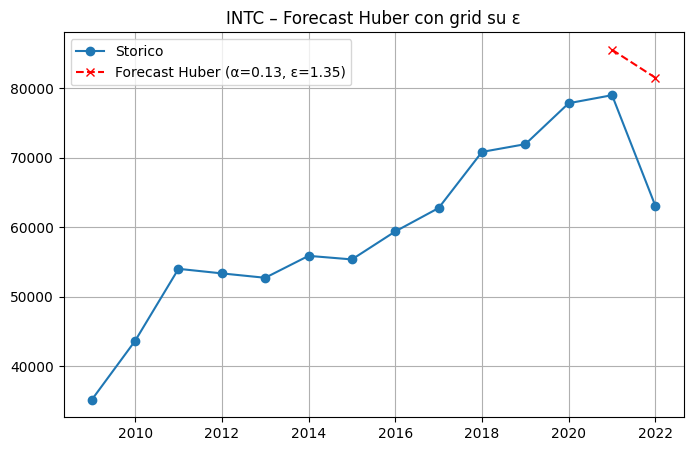

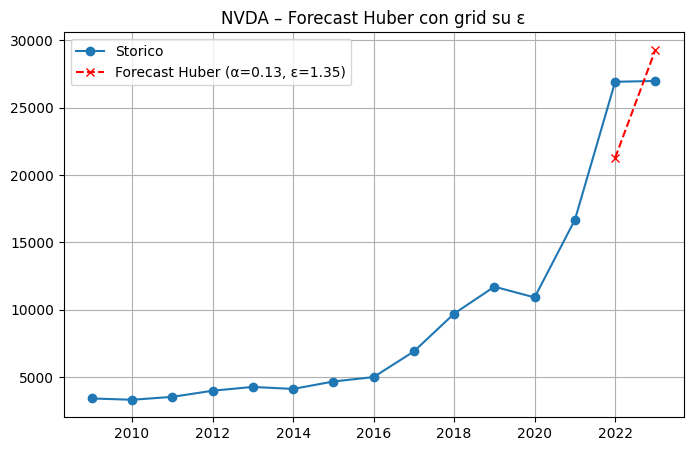


📊 Risultati Huber con best epsilon per outlier:
  Company  Alpha  Best_epsilon     MAE_huber  MAPE_huber
0    INTC   0.13          1.35  12513.075914   18.796363
1    NVDA   0.13          1.35   3977.098466   14.767500


In [41]:
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# --- PARAMETRI ---
mape_threshold = 15   # soglia per considerare un'azienda "outlier"
alpha_fixed = 0.13     # puoi fissare alpha oppure fare grid anche su alpha
eps_grid = [1.35, 2.0, 3.0, 5.0] # griglia di valori per epsilon

# --- FUNZIONE HUBER CON GRID SEARCH SU EPSILON ---
def huber_forecast_grid(df_extra, df_raw, company, alpha=alpha_fixed, eps_candidates=eps_grid):
    g = df_extra[df_extra["Company"] == company].copy()
    if g["Year"].nunique() < 4:
        return None

    # Features e target
    X = g[['logRev_lag1','EBITDA_margin_lag1','NI_margin_lag1',
           'logEBITDA_lag1','logNI_lag1',
           'SP500_growth_lag1','Nasdaq_growth_lag1','Inflation_lag1']]
    y = g['logRev']

    # Train-test (ultimi 2 anni fuori)
    cutoff = g["Year"].max() - 2
    X_train, y_train = X[g["Year"] <= cutoff], y[g["Year"] <= cutoff]
    X_test,  y_test  = X[g["Year"] > cutoff],  y[g["Year"] > cutoff]
    years_test = g.loc[g["Year"] > cutoff, "Year"].values

    best_mape = np.inf
    best_res = None

    for eps in eps_candidates:
        try:
            huber = HuberRegressor(alpha=alpha, epsilon=eps, max_iter=10000)
            huber.fit(X_train, y_train)

            # Predizioni
            y_pred_log = huber.predict(X_test)
            y_pred = np.expm1(y_pred_log)  
            y_true = np.expm1(y_test)

            # Metriche
            mae_val = mean_absolute_error(y_true, y_pred)
            mape_val = mean_absolute_percentage_error(y_true, y_pred) * 100

            # aggiorna se migliore
            if mape_val < best_mape:
                best_mape = mape_val
                best_res = {
                    "Company": company,
                    "Alpha": alpha,
                    "Best_epsilon": eps,
                    "MAE_huber": mae_val,
                    "MAPE_huber": mape_val,
                    "Years_test": years_test,
                    "Y_true": y_true,
                    "Y_pred": y_pred
                }
        except Exception as e:
            print(f"⚠️ Errore per {company}, eps={eps}: {e}")
            continue

    # Plot finale con la best epsilon
    if best_res:
        group_raw = df_raw[df_raw["Company"] == company]
        plt.figure(figsize=(8,5))
        plt.plot(group_raw["Year"], group_raw["Revenue"], marker="o", label="Storico")
        plt.plot(best_res["Years_test"], best_res["Y_pred"], "rx--",
                 label=f"Forecast Huber (α={alpha}, ε={best_res['Best_epsilon']})")
        plt.title(f"{company} – Forecast Huber con grid su ε")
        plt.legend(); plt.grid(True); plt.show()
        return {k: v for k, v in best_res.items() if k not in ["Years_test","Y_true","Y_pred"]}
    else:
        return None

# --- APPLICAZIONE AGLI OUTLIER ---
outliers = metrics_ridge_recursive[metrics_ridge_recursive["MAPE_model"] > mape_threshold]["Company"].tolist()
print(f"📌 Outlier individuati (MAPE > {mape_threshold}%): {outliers}")

huber_results = []
for comp in outliers:
    res = huber_forecast_grid(df_extra, df_raw, comp, alpha=alpha_fixed, eps_candidates=eps_grid)
    if res:
        huber_results.append(res)

huber_df = pd.DataFrame(huber_results)
print("\n📊 Risultati Huber con best epsilon per outlier:")
print(huber_df)



In [42]:
# --- COSTRUZIONE MODELLO IBRIDO (Ridge + Huber per outlier) ---

# copia dei risultati Ridge
hybrid_df = metrics_ridge_recursive.copy()

# sostituisci le metriche Ridge con quelle Huber per gli outlier
for _, row in huber_df.iterrows():
    comp = row["Company"]
    hybrid_df.loc[hybrid_df["Company"] == comp, "MAE_model"] = row["MAE_huber"]
    hybrid_df.loc[hybrid_df["Company"] == comp, "MAPE_model"] = row["MAPE_huber"]

# --- RISULTATI FINALI ---
print("\n📊 Metriche modello ibrido (Ridge + Huber outlier) per azienda:")
print(hybrid_df)

print("\n📊 Medie complessive modello ibrido:")
print("MAE modello   =", hybrid_df["MAE_model"].mean())
print("MAPE modello  =", hybrid_df["MAPE_model"].mean(), "%")



📊 Metriche modello ibrido (Ridge + Huber outlier) per azienda:
   Company     MAE_model  MAPE_model
0     AAPL  27061.327295    7.267924
1      AIG   3049.576279    5.833897
2     AMZN  10831.818614    2.108922
3      BCS   1307.966836    4.277027
4     GOOG  22974.957270    8.863518
5     INTC  12513.075914   18.796363
6      MCD   1452.555913    6.257908
7     MSFT   6621.310774    3.315666
8     NVDA   3977.098466   14.767500
9      PCG     11.040621    0.053093
10    PYPL    388.967057    1.431900

📊 Medie complessive modello ibrido:
MAE modello   = 8199.063185273477
MAPE modello  = 6.633974346220492 %


In [46]:
# --- RISULTATI SOLO PER LE AZIENDE NON OUTLIER ---
non_outliers = metrics_ridge_recursive[metrics_ridge_recursive["MAPE_model"] <= mape_threshold]

print("\n📊 Metriche solo per aziende NON outlier (Ridge):")
print(non_outliers)

print("\n📊 Medie complessive aziende NON outlier:")
print("MAE modello   =", non_outliers["MAE_model"].mean())
print("MAPE modello  =", non_outliers["MAPE_model"].mean(), "%")



📊 Metriche solo per aziende NON outlier (Ridge):
   Company     MAE_model  MAPE_model
0     AAPL  27061.327295    7.267924
1      AIG   3049.576279    5.833897
2     AMZN  10831.818614    2.108922
3      BCS   1307.966836    4.277027
4     GOOG  22974.957270    8.863518
6      MCD   1452.555913    6.257908
7     MSFT   6621.310774    3.315666
9      PCG     11.040621    0.053093
10    PYPL    388.967057    1.431900

📊 Medie complessive aziende NON outlier:
MAE modello   = 8188.835628661267
MAPE modello  = 4.37887269769233 %
